In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from importlib import reload
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo
import src.globals as globals
import seaborn as sns

from wrapper.models.bubble import BubbleBurster
from src.utils import get_topic_clusters, create_embeddings, load_or_create_measurements_df, load_and_process_movielens
from src.scoring_functions import cosine_sim, entropy, content_fairness
from wrapper.metrics.evaluation_metrics import SerendipityMetric, DiversityMetric, NoveltyMetric, TopicInteractionMeasurement, MeanNumberOfTopics

random_state = np.random.seed(42)
plt.style.use("seaborn")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

globals.initialize()

## Creating RecommenderSystem on MovieLens 

In [2]:
n_attrs=500
max_iter=1000
n_clusters=20

In [3]:
binary_ratings_matrix = load_and_process_movielens(file_path='data/ml-100k/u.data')

In [4]:
# Get user and item representations using NMF
user_representation, item_representation = create_embeddings(binary_ratings_matrix, n_attrs=n_attrs, max_iter=max_iter)

Loaded embeddings.


In [5]:
# Define topic clusters using NMF
item_topics = get_topic_clusters(binary_ratings_matrix, n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)

Loaded clusters.


## Cluster experiments

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_user_rep = scaler.fit_transform(user_representation)

kmeans = KMeans(init="random", n_clusters=n_clusters, n_init=10, max_iter=300, random_state=42)
user_clusters = kmeans.fit_predict(scaled_user_rep)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_user_rep)
pcadf = pd.DataFrame(data = principalComponents, columns = ['component_1', 'component_2'])
pcadf['predicted_cluster'] = user_clusters
print(pca.explained_variance_ratio_)

[0.02569702 0.02039239]


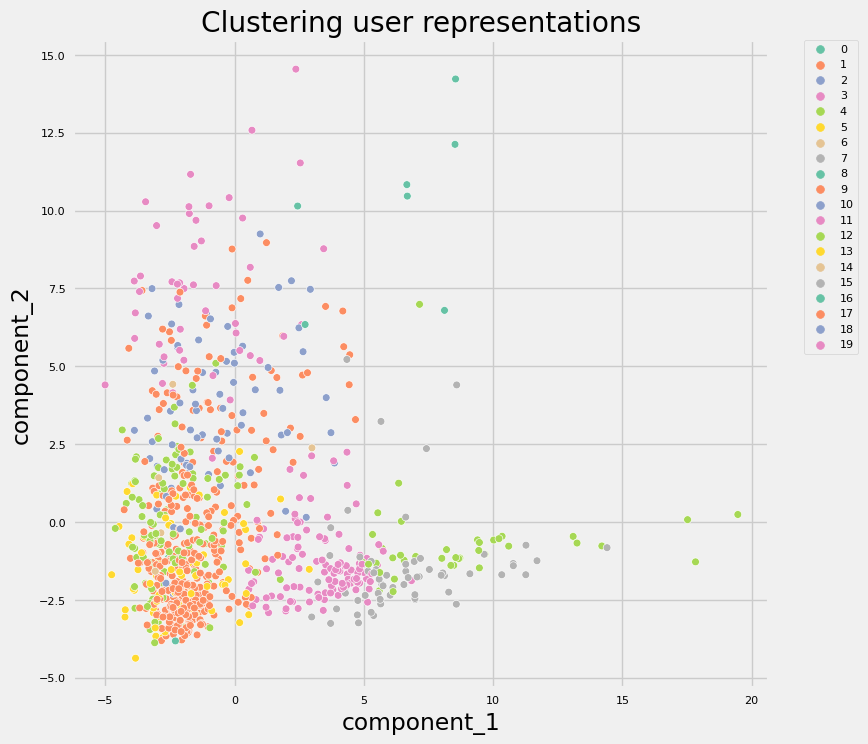

In [ ]:
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    x="component_1",
    y="component_2",
    data=pcadf,
    hue="predicted_cluster",
    palette="Set2",
)

scat.set_title("Clustering user representations")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.000s...
[t-SNE] Computed neighbors for 1682 samples in 0.100s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.111742
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.246788
[t-SNE] KL divergence after 4450 iterations: 0.848001


[Text(0.5, 1.0, '')]

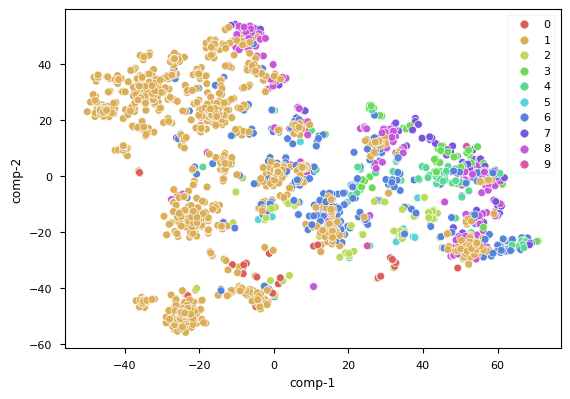

In [ ]:
# Using item_representation and KNN on co-occurence matrix to visualize item cluster
x = item_representation.T
y = item_topics

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=5000, random_state=42)
z = tsne.fit_transform(x)
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", n_clusters),
                data=df).set(title="")

In [ ]:
# Use embeddings as clusters
representations = np.vstack([item_representation.T, user_representation])
cluster_ids = np.argmax(representations, axis=1)
print(representations.shape)
print(cluster_ids.shape)

In [ ]:
item_clusters = np.argmax(item_representation.T, axis=1)
# count number of occurences in cluster_ids
cluster_counts = np.bincount(item_clusters)
print(cluster_counts)

# plot bar chart where x axis is cluster_id and height is number of items in a cluster
plt.bar(x=range(len(cluster_counts)), height=cluster_counts)
plt.xticks(range(len(cluster_counts)), range(0, len(cluster_counts)))
plt.show()

In [ ]:
item_clusters = np.argmax(user_representation, axis=1)
# count number of occurences in cluster_ids
cluster_counts = np.bincount(item_clusters)
print(cluster_counts)

# plot bar chart where x axis is cluster_id and height is number of items in a cluster
plt.bar(x=range(len(cluster_counts)), height=cluster_counts)
plt.xticks(range(len(cluster_counts)), range(0, len(cluster_counts)))
plt.show()

In [ ]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns

# Using user representation and clusters from NMF to visualize user separation
x = representations
y = cluster_ids

perplexity = 45
tsne = TSNE(perplexity=perplexity, n_components=2, verbose=0, random_state=42)
z = tsne.fit_transform(x)

In [ ]:
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
df['rep_type'] = 'item'
df.loc[df.index >= len(item_representation[0]), 'rep_type'] = 'user'

In [ ]:
# plot tsne
plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(20, 20))
print(f"Number of clusters using NMF: {n_attrs}.")
sns.scatterplot(x="comp-1", y="comp-2", hue=df[df['rep_type'] == 'item'].y.tolist(),
                palette=sns.color_palette("hls", n_attrs), alpha=0.2,
                data=df[df['rep_type'] == 'item']).set(title="")
sns.scatterplot(x="comp-1", y="comp-2", hue=df[df['rep_type'] == 'user'].y.tolist(),
                palette=sns.color_palette("hls", n_attrs), alpha=1,
                data=df[df['rep_type'] == 'user']).set(title="")

for ind in df.index:
    plt.text(x=df['comp-1'][ind], y=df['comp-2'][ind], s=df['y'][ind], color='black', fontsize=6, horizontalalignment='center', verticalalignment='center')

plt.title(f'TSNE with perplexity={perplexity}')
plt.suptitle(f'Opaque points are items. Others are users.')
plt.show()